In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pathlib
import pandas as pd

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [4]:
RS = 7345

# Загрузка данных

In [5]:
train = pd.read_csv('data/train.csv', index_col='pair_id')
test = pd.read_csv('data/test.csv', index_col='pair_id')

In [6]:
train.head()

,name_1,name_2,is_duplicate
pair_id,,,
0,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
1,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
2,Tress A/S,Longyou Industries Park Zhejiang,0
3,Wpt Mexico Sa De Cv,Hopkins Mfg. De Mexico S De Rl De Cv,0
4,National Bank Of,Action International,0


In [7]:
test.head()

,name_1,name_2
pair_id,,
1,Sun Blinds Decoration Inc.,Indl De Cuautitlan Sa Cv
2,Eih Ltd.,"Dongguan Wei Shi Plastic Product Co., Ltd."
3,Jsh Ltd. (Hk),Arab Shipbuilding And Repair Yard C
4,Better Industrial Ltd.,Farmacap Industria E Comercio Ltda
5,Equipos Inoxidables Del Norte Sa De Cv,Bel Inc.


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 459450 entries, 0 to 459449
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   name_1        459450 non-null  object
 1   name_2        459450 non-null  object
 2   is_duplicate  459450 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 14.0+ MB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213249 entries, 1 to 213249
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   name_1  213249 non-null  object
 1   name_2  213249 non-null  object
dtypes: object(2)
memory usage: 4.9+ MB


# Статистика таргета

In [10]:
train.is_duplicate.value_counts()

0    455742
1      3708
Name: is_duplicate, dtype: int64

In [11]:
train[train.is_duplicate==1].sample(15)

,name_1,name_2,is_duplicate
pair_id,,,
95629,Bridgestone Firestone De Argentina Saic,Bridgestone Firestone Venezolana,1
355503,Exxonmobil Chemical Co.,Exxonmobil Chemical Co. Baytown Chemical Plant,1
123847,Pirelli Neumaticos S.A. De C.V.,Pirelli Neumaticos S.A.I.C.,1
6434,Giti Tire Mfg. L.T.D.,Giti Tire Mfg. (Usa),1
257975,Eni Jr286 Inc.,Eni Jr286 Inc. (Code 26 273374500),1
68626,WRIGHT ASPHALT PRODUCTS,Wright Asphalt Products Co.,1
4885,"Thai Bridgestone Co., Ltd.",Bridgestone India,1
205695,"Michelin Siam Co., Ltd.",Michelin India Technology Center,1
72616,Arlanxeo,"Arlanxeo Singapore Pte., Ltd.",1


In [12]:
train[train.is_duplicate==0].sample(15)

,name_1,name_2,is_duplicate
pair_id,,,
276811,S R International,Tecnica Y Equipos Hidroneumaticos Sa De Cv,0
17657,Eagle Enterprises (Private) Ltd.,Azam Enterprises,0
337585,Hae In Corp.,Monoprene Internationals.,0
230939,Council Of Scientific & Industrial Research,Vinko Auto Industries Ltd.,0
437612,Dow Chemical,Gold Star Rubber & Chemical Co.,0
286927,Mti Llc,Parker Hannifin Industries Hose,0
308324,Horizon Rubber Products,Us. Rubber Corp.,0
108105,Panini Sp A,Metro Spinning Ltd.,0
395157,Samsung Electronics Home Appliance,G B Corporation,0


# Очистка данных

In [13]:
import pycountry
import re

In [14]:
countries = [country.name.lower() for country in pycountry.countries]

In [15]:
train["name_1"] = train["name_1"].str.lower()
train["name_2"] = train["name_2"].str.lower()

test["name_1"] = test["name_1"].str.lower()
test["name_2"] = test["name_2"].str.lower()

In [16]:
train[train.name_1.str.contains("gmbh")]

,name_1,name_2,is_duplicate
pair_id,,,
34,isoliererzeugnisse grobrohrsdorf gmbh,total rumunia,0
377,dortmunder gussasphalt gmbh & co. kg,bitoumina s.a.,0
403,celanese chemicals europe gmbh,inreco - emulsja sp. z o.o.,0
540,tremco illbruck group gmbh,wakol gmbh,0
631,rasco bitumentechnik gmbh,technpvinyl polymers india ltd.,0
...,...,...,...
458876,binne & sohn gmbh & co kg,buscher hoffmann,0
458978,mct gmbh & co. kg,valli zabban,0
459032,mct misch & compoundier technik gmbh,nknh,0


In [17]:
legal_entities = ["ltd.", "co.", "inc.", "b.v.", "s.c.r.l.", "gmbh", "pvt."]

for entity in tqdm(legal_entities):
    train.replace(re.compile(f"\s+{entity}\s*"), "", inplace=True)
    test.replace(re.compile(f"\s+{entity}\s*"), "", inplace=True)

  0%|          | 0/7 [00:00<?, ?it/s]

In [18]:
train.head()

,name_1,name_2,is_duplicate
pair_id,,,
0,iko industries,"enormous industrial trade,",0
1,apcotex industries,technocraft industries (india),0
2,tress a/s,longyou industries park zhejiang,0
3,wpt mexico sa de cv,hopkins mfg. de mexico s de rl de cv,0
4,national bank of,action international,0


In [19]:
test.head()

,name_1,name_2
pair_id,,
1,sun blinds decoration,indl de cuautitlan sa cv
2,eih,"dongguan wei shi plastic product,"
3,jsh(hk),arab shipbuilding and repair yard c
4,better industrial,farmacap industria eercio
5,equipos inoxidables del norte sa de cv,bel


In [20]:
train.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)
test.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)

In [21]:
for country in tqdm(countries):
    train.replace(re.compile(country), "", inplace=True)
    test.replace(re.compile(country), "", inplace=True)

  0%|          | 0/249 [00:00<?, ?it/s]

In [22]:
train.replace(re.compile(r"[^\w\s]"), "", inplace=True)
test.replace(re.compile(r"[^\w\s]"), "", inplace=True)

In [23]:
train.sample(25)

,name_1,name_2,is_duplicate
pair_id,,,
315673,dongguan city cheung fat plastic ma,riintl,0
296226,dana industrias,buddha metal industries,0
435266,n j international,chongqing jinmao imp exp,0
389580,joss holding,polymerteam,0
163924,force sports tech trading,ag trading,0
379013,trb international,manufactura de fibras sinteticas s,0
68661,beijing barcoleyard electronic technologyporation,ajc international,0
19549,sertrading br,al habib genral trading,0
64863,toyoda gosei rubber s a de c v,roop rubber mills,0


In [24]:
train[train.is_duplicate==1].sample(25)

,name_1,name_2,is_duplicate
pair_id,,,
358105,lindner aktiengesellschaft,ооолинднер,1
369697,bridgestone americas tire,bridgestone,1
32761,sociedade michelin de participacoes indust eer...,michelin private,1
106248,bridgestone firestone de saic,bridgestone,1
240561,bridgestone ncr,bridgestone automotive,1
209727,plastay kimya,plastay kimya sanayi ve ticaret a s,1
161352,exxonmobil quimica,exxonmobil chemical americas po box 4549 houston,1
42060,michelin na asrc,michelin research and development center,1
259262,sumitomo rubber industries usa,sumitomo rubber industriesusa,1


In [25]:
test.sample(25)

,name_1,name_2
pair_id,,
90804,mitre sports international,ransome sporting goods
120823,soccer international,polymeric resourcesp
30393,symtake chemical,dro chemicals
104992,tulip diagnostics,uci
177390,united rubber industries,wam
81956,celanese chemicals europe,полимаркет ооо
159128,ningbo auto parts breton,parthporation
169975,puma energy international bv,varo energy
72711,guangzhou city polymer materials,guangzhou xianyumerce


# Простые метрики сходства строк

In [26]:
from strsimpy.levenshtein import Levenshtein
from strsimpy.normalized_levenshtein import NormalizedLevenshtein

In [27]:
levenshtein = Levenshtein()

train["levenstein"] = train.progress_apply(lambda r: levenshtein.distance(r.name_1, r.name_2), axis=1)
test["levenstein"] = test.progress_apply(lambda r: levenshtein.distance(r.name_1, r.name_2), axis=1)

  0%|          | 0/459450 [00:00<?, ?it/s]

  0%|          | 0/213249 [00:00<?, ?it/s]

In [28]:
train.head()

,name_1,name_2,is_duplicate,levenstein
pair_id,,,,
0,iko industries,enormous industrial trade,0,15.0
1,apcotex industries,technocraft industries,0,9.0
2,tress as,longyou industries park zhejiang,0,26.0
3,wpt sa de cv,hopkins mfg de s de rl de cv,0,19.0
4,national bank of,action international,0,14.0


In [29]:
normalized_levenshtein = NormalizedLevenshtein()

train["norm_levenstein"] = train.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1, r.name_2),
                                                axis=1)
test["norm_levenstein"] = test.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1, r.name_2),
                                              axis=1)

  0%|          | 0/459450 [00:00<?, ?it/s]

  0%|          | 0/213249 [00:00<?, ?it/s]

In [30]:
train.head()

,name_1,name_2,is_duplicate,levenstein,norm_levenstein
pair_id,,,,,
0,iko industries,enormous industrial trade,0,15.0,0.600000
1,apcotex industries,technocraft industries,0,9.0,0.409091
2,tress as,longyou industries park zhejiang,0,26.0,0.812500
3,wpt sa de cv,hopkins mfg de s de rl de cv,0,19.0,0.655172
4,national bank of,action international,0,14.0,0.700000


In [31]:
test.head()

,name_1,name_2,levenstein,norm_levenstein
pair_id,,,,
1,sun blinds decoration,indl de cuautitlan sa cv,20.0,0.833333
2,eih,dongguan wei shi plastic product,29.0,0.906250
3,jshhk,arab shipbuilding and repair yard c,33.0,0.942857
4,better industrial,farmacap industria eercio,15.0,0.600000
5,equipos inoxidables del norte sa de cv,bel,35.0,0.921053


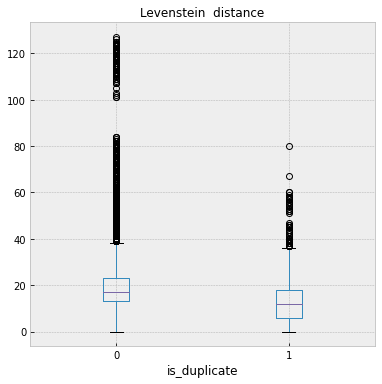

In [32]:
plt.figure(figsize=(6,6))

train.boxplot("levenstein", by="is_duplicate", ax=plt.gca())
plt.suptitle("")
plt.title("Levenstein  distance", fontsize=12);

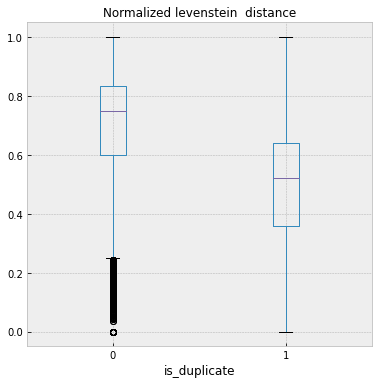

In [33]:
plt.figure(figsize=(6,6))

train.boxplot("norm_levenstein", by="is_duplicate", ax=plt.gca())
plt.suptitle("")
plt.title("Normalized levenstein  distance", fontsize=12);

# Базовая модель

In [34]:
FTS = ["levenstein", "norm_levenstein"]
THR = 0.9

In [35]:
split = StratifiedShuffleSplit(1, train_size=0.8, random_state=42)
tridx, cvidx = list(split.split(train[FTS], train["is_duplicate"]))[0]

In [36]:
model = LogisticRegression(class_weight="balanced")
model.fit(train.iloc[tridx][FTS].values,
          train.iloc[tridx]["is_duplicate"].values)

LogisticRegression(class_weight='balanced')

In [37]:
tr_preds = model.predict_proba(train.iloc[tridx][FTS].values)
cv_preds = model.predict_proba(train.iloc[cvidx][FTS].values)

In [38]:
tr_preds = (tr_preds[:, 1] > THR).astype(np.int)
cv_preds = (cv_preds[:, 1] > THR).astype(np.int)

In [39]:
print(classification_report(train.iloc[tridx]["is_duplicate"].values, tr_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    364594
           1       0.24      0.15      0.18      2966

    accuracy                           0.99    367560
   macro avg       0.62      0.57      0.59    367560
weighted avg       0.99      0.99      0.99    367560



In [40]:
print(classification_report(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     91148
           1       0.24      0.14      0.18       742

    accuracy                           0.99     91890
   macro avg       0.62      0.57      0.59     91890
weighted avg       0.99      0.99      0.99     91890



In [41]:
print(f1_score(train.iloc[tridx]["is_duplicate"].values, tr_preds))
print(f1_score(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

0.18235417982733207
0.17591801878736124
